(Note that all units unless otherwise mentioned are SI units.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
from multislice import prop,prop_utils

Importing all the required libraries.

In [2]:
def find_edge(x,grid_size,n):
    if x<(grid_size/2):
        if x>n:
            return n
        else :
            return int(np.floor(x / 2) * 2)
    else :
        if (grid_size-x)>n:
            return n
        else :
            return int(np.floor((grid_size-x) / 2) * 2)

*find_edge* : get the distance of the pixel of interest from the edge of the array
* *Inputs* : x - co-ordinate of the pixel (where the wavefront in the focal plane hits it's maximum value), grid_size,      n - length of the spot we would like to capture
* *Outputs* : if the desired length 'n' can be safely captured, the output is n, else the output is the number of pixels one can capture (the only reason this would happen is if the focal spot is too close to the edge of the output wavefront due to tilt (remember that intput wavefront gets tilted))

In [3]:
def get_focal_spot(focal_plane_,grid_size,n=250):
    x_,y_ = np.where(focal_plane_==np.max(focal_plane_))
    x_ = x_[0]
    y_ = y_[0]
 
    x1 = find_edge(x_,grid_size,n)
    y1 = find_edge(y_,grid_size,n)
    
    print('max_loc :',x_,y_,x1,y1)
    
    focal_spot_ = np.zeros((2*n,2*n))
    if (x1+y1) != 2*n:
        focal_spot_[n-x1:n+x1,n-y1:n+y1] = focal_plane_[x_-x1:x_+x1,y_-y1:y_+y1]
    else :
        focal_spot_[:,:] = focal_plane_[x_-n:x_+n,y_-n:y_+n]
    return focal_spot_,x_,y_,np.max(focal_plane_)

*get_focal_spot* : get the region in the output plane containing the focal spot
* *Inputs* : focal_plane - the wavefront at the focal plane, grid_size, n - half-size of the array to be returned
* *Outputs* : a numpy array containing the focal spot

In [4]:
def make_zp_from_rings(n,grid_size):
    zp = np.zeros((grid_size,grid_size))
    for i in range(n):
        if i%2 == 1 :
            ring_ = np.load('ring_'+str(i)+'.npy')
            ring_ = tuple((ring_[0],ring_[1]))
            zp[ring_] = 1
    return zp

*make_zp_from_rings* : make a zone plate from the rings which were created earlier.
* *Inputs* : n - number of rings, grid_size 
* *Outputs* : a numpy array containing the zone plate

grid_size  :  40000
step_xy  :  2.75006875172e-09
energy(in eV)  :  10000
wavelength in m  :  1.23984e-10
focal_length  :  0.005
zp_coords  :  [-5.5e-05, 5.5e-05, -5.5e-05, 5.5e-05]
delta  :  2.9912e-05
beta  :  2.2073e-06


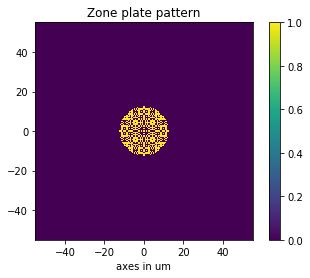

In [5]:
os.chdir(os.getcwd()+str('/rings'))
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,' : ',parameters[i])
zp_coords = parameters['zp_coords']
grid_size = parameters['grid_size']
zp = make_zp_from_rings(250,int(grid_size))
plt.imshow(zp,extent=np.array(zp_coords)*1e6)
plt.title('Zone plate pattern')
plt.xlabel('axes in um')
plt.colorbar()
plt.show()

Importing zone plate pattern and the parameters associated with it. Plotting the zone plate after creating it from the rings. One needs to save the image with high dpi to clearly see the zone plate. 

In [6]:
beta  = parameters['beta']
delta = parameters['delta']
step_xy = parameters['step_xy']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
L = step_xy*np.shape(zp)[0] 
m,n = np.shape(zp)
zp_thickness = 2e-6

*Setting up the parameters for the simulation*<br>
* *beta and delta*       : delta and beta at the relevant energy <br>
* *step_xy*              : sampling in the xy plane<br>
* *wavel*                : wavelength<br>
* *f*                    : focal length<br>
* *wavefront*            : wavefront that is initialzed with magnitude of 1 and phase of 0<br>
* *L*                    : support length<br>
* *m,n*                  : dimensions of input zp<zp>
* *zp_thickness*         : thickness of zone plate <br>

In [7]:
i = 0.5 #Angle in degrees
theta = (i)*(np.pi/180)
slope = np.tan(theta)
x = np.linspace(zp_coords[0],zp_coords[1],n)
X,Y = np.meshgrid(x,x)
z1 = 2*np.pi*(1/wavel)*slope*X
del X,Y,x
wave_in = np.multiply(np.ones(np.shape(zp),dtype='complex64'),np.exp(1j*(z1)))
del z1

Creating the input wave for the simulation. The input wave has a position(along one axis) dependent phase to simulate the effect of tilting the zone plate (instead of tilting the zone plate itself though tilting the zone plate might be more efficient in the long run)

In [8]:
number_of_steps =  prop_utils.number_of_steps(step_xy,wavel,zp_thickness)*2
wave_exit,L1 = prop_utils.optic_illumination(wave_in,zp,delta,beta,zp_thickness,
                                              step_xy,wavel,number_of_steps,0,0)
del zp,wave_in

suggested step size : 6.09988235511e-07
number of steps required for propogation through the zone plate : 5
propogator to be used : Transfer Function
Fresnel Number : 487990588.409


Propogation through zone plate...: 100%|██████████| 10/10 [15:03<00:00, 90.31s/it]


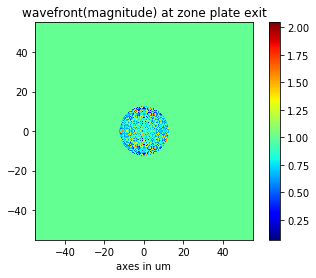

In [9]:
plt.imshow(np.abs(wave_exit),extent=np.array([-L1/2,L1/2,-L1/2,L1/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at zone plate exit')
plt.colorbar()
plt.show()

In [10]:
step_z = f
p = prop_utils.decide(step_z,step_xy,L,wavel)
print('Propagation to focal plane')
print('Fresnel Number :',((L**2)/(wavel*step_z)))
wave_focus,L2 = p(wave_exit,step_xy,L,wavel,step_z)

propogator to be used : Single Fourier Transform
Propagation to focal plane
Fresnel Number : 19519.6235364


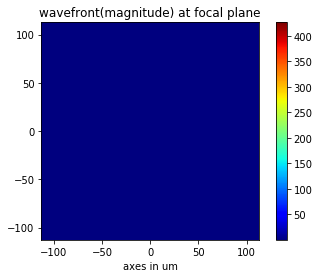

In [11]:
plt.imshow(np.abs(wave_focus),extent=np.array([-L2/2,L2/2,-L2/2,L2/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at focal plane')
plt.colorbar()
plt.show()

The focal spot is ~50 wide and one can't see it when the whole wavefront (40k by 40k) is visualized ! 
Another thing one can notice is the faint outline of a square, this is because the output grid dimensions are different from the input grid dimensions and the length of the side of this square is nothing but the support length of the input plane.

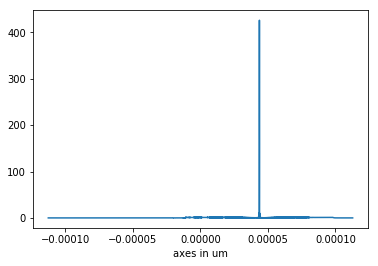

slice in x-direction along the focal plane


In [12]:
x = np.linspace(-1,1,grid_size)*L2/2
plt.plot(x,abs(wave_focus)[int(grid_size/2),:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal plane')

The above plot shows that the location of the focal spot has shifted due to the tilt of the input wave.

In [13]:
focal_spot_size = 100
focal_spot,x_,y_,max_val = get_focal_spot(np.abs(wave_focus),grid_size,focal_spot_size)

max_loc : 20000 27745 100 100


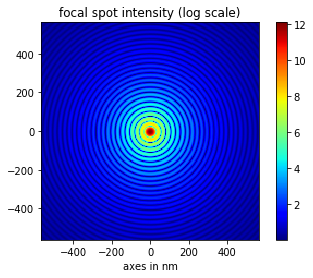

In [14]:
plt.imshow(np.log(focal_spot**2+1),extent = np.array([-1,1,-1,1])*(focal_spot_size)*(L2/grid_size)*(1e9),cmap='jet')
plt.title('focal spot intensity (log scale)')
plt.xlabel('axes in nm')
plt.colorbar()
plt.show()